In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from skimage import io
from torchvision.transforms import ToTensor, Lambda
import torchvision
from torchvision.models import resnet18, resnet50
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

In [3]:
class Imageloading(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.annotations = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform
  
  def __len__(self):
    return(len(self.annotations))
  
  def __getitem__(self, index):
    img_path = os.path.join(self.root_dir, self.annotations.iloc[index,1])
    image = io.imread(img_path)
    y_label = torch.tensor(int(self.annotations.iloc[index,2]))
    #print(y_label)
    if self.transform:
      image = self.transform(image)

    return(image, y_label)

# RESNET

In [48]:
from torchvision.transforms import transforms

tfm = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.RandomCrop((75,75), fill=0, padding_mode='constant'),

    transforms.RandomChoice([
        transforms.ColorJitter(brightness=0.5),
        transforms.ColorJitter(contrast=0.5),
        transforms.ColorJitter(hue=0.5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1, saturation=0.1),
        transforms.ColorJitter(brightness=0.5, contrast=0.5, hue=0.3, saturation=0.5),
        transforms.ColorJitter(brightness=0.7, contrast=0.7, hue=0.5, saturation=0.7)
    ]),

    transforms.RandomChoice([
        transforms.RandomRotation((0,0)),
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomVerticalFlip(p=1),
        transforms.RandomRotation((90,90)),
        transforms.RandomRotation((180,180)),
        transforms.RandomRotation((270,270)),
    ]),
    transforms.Compose([
        transforms.RandomHorizontalFlip(p=1),
        transforms.RandomRotation((270,270))
    ]),


    #transforms.ColorJitter(brightness=1, contrast=1, hue=0.2, saturation=5),
    transforms.RandomAdjustSharpness(2.0),
    #transforms.
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [49]:
dataset = Imageloading(csv_file='/content/drive/MyDrive/DATA690Project2/newlabels.csv',
                       root_dir='/content/drive/MyDrive/DATA690Project2/train2', transform = tfm)


In [50]:
trainset, valset = torch.utils.data.random_split(dataset,[800,74])
train_loader = DataLoader(trainset, batch_size=50, shuffle=True)
val_loader = DataLoader(valset, batch_size=50, shuffle=True)

In [51]:
data_iter = iter(train_loader)
images, labels = data_iter.next()

In [52]:
images.shape

torch.Size([50, 3, 75, 75])

In [53]:
print("Yes",labels.tolist().count(1))
print("No",labels.tolist().count(0))

Yes 17
No 33


In [54]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,10))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

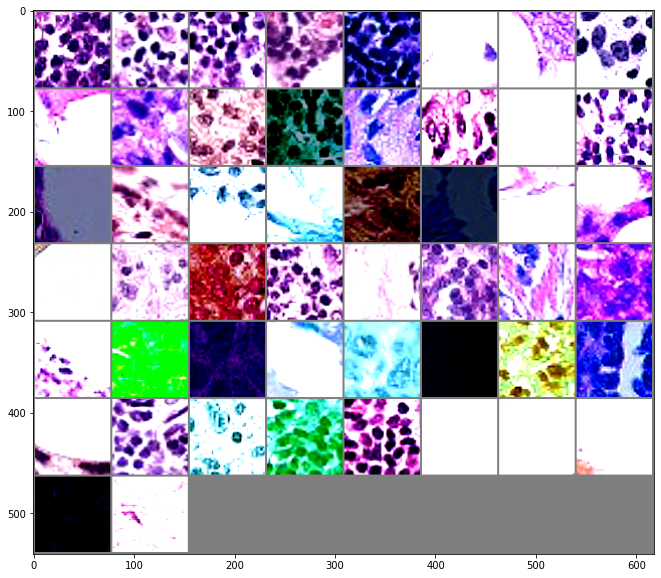

In [55]:
import torchvision
import matplotlib.pyplot as plt
import numpy as np

imshow(torchvision.utils.make_grid(images))

In [56]:
images.shape, labels.shape

(torch.Size([50, 3, 75, 75]), torch.Size([50]))

In [57]:
model2 = resnet50(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [58]:
model2.fc = nn.Linear(in_features=2048, out_features=576, bias=True)
model2.fc2 = nn.Linear(in_features=576, out_features=2)

In [59]:
model2.to('cuda')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [60]:
#hyperparamters
epochs = 10
#batch_size =10
lr = 0.0009
n_steps = len(train_loader)
device = 'cuda'
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr = lr, weight_decay=0.0001)
final_losses = []
n_steps = len(train_loader)
for epoch in range(epochs):
  for i, (image, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = model2(images)
    outputs = outputs.sigmoid()
    #outputs = outputs.softmax(dim=1)
    #print(outputs.shape, labels.shape)
    #outputs = outputs[:,-1]
    loss = criterion(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if(i+1)%6 == 0:
      print(f'Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_steps}], Loss: {loss.item():.4f}')
  final_losses.append(loss.detach())

Epoch [1/10], Step [6/16], Loss: 5.5052
Epoch [1/10], Step [12/16], Loss: 5.3675
Epoch [2/10], Step [6/16], Loss: 5.3623
Epoch [2/10], Step [12/16], Loss: 5.3622
Epoch [3/10], Step [6/16], Loss: 5.3621
Epoch [3/10], Step [12/16], Loss: 5.3621
Epoch [4/10], Step [6/16], Loss: 5.3621
Epoch [4/10], Step [12/16], Loss: 5.3621
Epoch [5/10], Step [6/16], Loss: 5.3621
Epoch [5/10], Step [12/16], Loss: 5.3622
Epoch [6/10], Step [6/16], Loss: 5.3622
Epoch [6/10], Step [12/16], Loss: 5.3622
Epoch [7/10], Step [6/16], Loss: 5.3622
Epoch [7/10], Step [12/16], Loss: 5.3623
Epoch [8/10], Step [6/16], Loss: 5.3623
Epoch [8/10], Step [12/16], Loss: 5.3624
Epoch [9/10], Step [6/16], Loss: 5.3624
Epoch [9/10], Step [12/16], Loss: 5.3625
Epoch [10/10], Step [6/16], Loss: 5.3626
Epoch [10/10], Step [12/16], Loss: 5.3626


In [61]:
classes = ["No", "Yes"]
with torch.no_grad():
  n_correct = 0
  n_samples= 0
  n_class_correct = [0 for i in range(50)]
  n_class_samples = [0 for i in range(50)]
  for images, labels in train_loader:
    images = images.to(device)
    labels= labels.to(device)
    outputs = model2(images)
    _,predicted = torch.max(outputs,1)
    n_samples+= labels.size(0)
    n_correct+= (predicted==labels).sum().item()
    
    for i in range(50):
      label = labels[i]
      pred = predicted[i]
      if(label==pred):
        n_class_correct[label] += 1
      n_class_samples[label] +=1
  acc = 100*(n_correct/n_samples)
  print(f'Accuracy of the network: {acc} %')
    
  for i in range(2):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 55.25 %
Accuracy of No: 40.853658536585364 %
Accuracy of Yes: 78.24675324675324 %


In [62]:
from sklearn.metrics import classification_report
print(classification_report(y_true=labels.tolist(), y_pred=predicted.tolist()))

              precision    recall  f1-score   support

           0       0.78      0.48      0.60        29
           1       0.53      0.81      0.64        21

    accuracy                           0.62        50
   macro avg       0.65      0.65      0.62        50
weighted avg       0.67      0.62      0.61        50



In [64]:
classes = ["No", "Yes"]
with torch.no_grad():
  n_correct = 0
  n_samples= 0
  n_class_correct = [0 for i in range(50)]
  n_class_samples = [0 for i in range(50)]
  for images, labels in val_loader:
    images = images.to(device)
    labels= labels.to(device)
    outputs = model2(images)
    _,predicted = torch.max(outputs,1)
    n_samples+= labels.size(0)
    n_correct+= (predicted==labels).sum().item()
    
    for i in range(24):
      label = labels[i]
      pred = predicted[i]
      if(label==pred):
        n_class_correct[label] += 1
      n_class_samples[label] +=1
  acc = 100*(n_correct/n_samples)
  print(f'Accuracy of the network: {acc} %')
    
  for i in range(2):
    acc = 100.0 * n_class_correct[i] / n_class_samples[i]
    print(f'Accuracy of {classes[i]}: {acc} %')

Accuracy of the network: 55.4054054054054 %
Accuracy of No: 40.0 %
Accuracy of Yes: 88.88888888888889 %


In [65]:
from sklearn.metrics import classification_report
print(classification_report(y_true=labels.tolist(), y_pred=predicted.tolist()))

              precision    recall  f1-score   support

           0       0.86      0.43      0.57        14
           1       0.53      0.90      0.67        10

    accuracy                           0.62        24
   macro avg       0.69      0.66      0.62        24
weighted avg       0.72      0.62      0.61        24



In [76]:
torch.save(model2,f='/content/drive/MyDrive/DATA690Project2/resnetmodel.pth')